## **1. Introducció**

League of Legends (LoL) és un videojoc del gènere Multiplayer Online Battle Arena (MOBA) desenvolupat i publicat per Riot Games i és el videojoc més popular d'aquest gènere. El joc consisteix a jugar partides autocontingudes, fent referència al fet que jugar una partida no afecta directament les pròximes partides, entre dos equips diferents (Blau i Vermell) que han de destruir la base (nexe) de l'equip contrari. Aquesta és l'única manera de guanyar la partida, assumint que cap equip es rendeixi, ja que és impossible quedar empatats. 

Ara, es tracta d'un joc d'estratègia i, per tant, hi ha diferents mecàniques del joc que donen avantatge a l'equip que l'aconsegueixi o l'aprofiti millor. En conseqüència, aquestes mecàniques poden ser la clau per a guanyar una partida, tot i que hi ha moltes més variables a tenir en compte.

L'objectiu d'aquest notebook és analitzar el conjunt de dades o dataset de Partides Competitives (SOLO-Q) de League of Legends i veure si, amb les dades disponibles, es pot entrenar un model de predicció capaç de predir quin serà l'equip que guanyarà la partida. S'ha de tenir en compte que aquest dataset és de l'any 2019 i, per tant, pot no reflectir amb exactitud l'estat actual del joc i es tindrà en compte a les conclusions.

## **2. Explicació del _Gameplay_**

Per a poder entendre i justificar les característiques del dataset, cal entendre algunes de les mecàniques d'una partida classificatòria de League of Legends (versió 2019).

#### **Objectiu principal**
L'objectiu principal de la partida és el **Nexe** enemic, situat en la seva base: si el teu Nexe és destruït, perds la partida; si destrueixes el Nexe enemic, guanyes. El nexe està protegit per dues Torretes interiors que cal destruir primer. Tota l'estratègia del joc cau en jugar al voltant dels objectius. Cada jugador de l'equip escull un campió diferent (personatge amb diferents atacs i habilitats).

#### **Estructures defensives**

* **Inhibidors**: cada equip té tres Inhibidors, un per línia. Es troben la base de l'equip i cada una és protegida per una Torreta que ha de ser destruïda. En destruir-ne un, l'equip passa a generar minions millorats només en aquella línia, facilitant l'avanç per ella. Mínim un ha de ser destruït per accedir al Nexe.

* **Torretes**: poden atacar als jugadors enemics si peguen a l'enemic en el seu radi. Protegeixen les línies i la base. Cada línia en té tres, tenint en compte la de l'inhibidor, i han de ser destruïdes en ordre per a cada línia. La primera Torreta destruïda atorga una bonificació d'or.

#### **Monstres èpics**

* **Herald de l'escletxa**: apareix en el minut 10:00 de la partida. L'equip que el derroti pot aconseguir un objecte que invoca l'Herald, que ajuda a destruir les estructures enemigues d'una línia.

* **Dracs**: apareixen reiteradament durant el transcurs de la partida (canviant d'element) fins que un equip n'aconsegueixi quatre. Depenent de l'element, augmenta estadístiques (dany, resistències, velocitat, etc.) de l'equip.

* **Drac ancià**: després de que un equip hagi matat a quatre dracs, la seva aparició es canvia per la del drac ancià, aquest drac atorga estadistiques que tenen un impacte major sobre les estadistiques de l'equip.

* **Baró Nashor**: apareix en el minut 20:00 de la partida. Atorga una millora temporal que incrementa la força de l'equip i dels minions, facilitant l'avanç per les línies i la base enemiga.<br><br>

Amb els diferents objectius, farmeant minions i monstres de la jungla i aconseguint morts enemigues (la primera mort atorga una bonificació d'or) s'atorga or i experiència a l'equip que els aconsegueix. També es pot col·locar un element de visió al mapa que s'anomena "Ward" o Guarda, en català. El guarda permet veure si un enemic es mou d'una línia a una altra o si s'estan fent un objectiu, és a dir, atorga visió per a tenir un control sobre les decisions de l'equip rival. Es pot treure la visió de l'equip rival, atorgant una mica d'or. L'or permet la compra d'objectes que milloren les estadístiques dels campions, mentre que l'experiència permet pujar de nivell les habilitats, facilitant l'obtenció de més objectius i, finalment, la victòria.

Resumint com funciona la partida: Els jugadors apareixen en la base en el minut 0:00, anant a les seves línies per a jugar. Durant el transcurs, intentaran avançar per les línies, destruint les torretes, l'inhibidor i finalment, el nexe i les seves torretes. També aniran matant als minions, monstres menors i campions enemics, alhora que intenten aconseguir els monstres. Podran comprar amb l'or aconseguit per enfortir-se i col·locar visió pel mapa per tenir un control més elevat en la partida. Cada cop que un jugador mor, reapareix en un temps determinat pel seu nivell. Per tant, a final de partida, tardaran més en reaparèixer.



<p align="center">
  <img src="models/Mapa League of Legends simplificat.png" width="750">
</p>


## **3. Dependències**

En aquest apartat es troben totes les llibreries que s'han utilitzat en l'anàlisi del nostre dataset i, per tant, es requereixen per poder executar correctament el nostre notebook:

In [3]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score

## **4. Anàlisi exploratori del dataset**

Per començar, és necessari analitzar i comprendre el dataset, tant les dades com el que representen. És un pas essencial per a poder identificar quin tipus d'informació tenim disponible i com pot influir en la construcció del nostre model de classificació (predir l'equip guanyador, variable objectiu "hasWon").

In [4]:
df = pd.read_csv("./datasets/lol_ranked_games.csv")
pd.set_option("display.max_columns", None)
df

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
0,4546233126,1443000,1,10,-448,-147,-0.2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,5,21,3,5
1,4546233126,1443000,1,12,-1306,-925,-0.6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,11,6,28,4,6
2,4546233126,1443000,1,14,2115,2578,0.4,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,10,11,12,35,4,6
3,4546233126,1443000,1,16,1195,2134,0.4,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,10,12,12,45,6,10
4,4546233126,1443000,1,18,2931,4382,0.6,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,13,13,16,49,7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242567,4402156483,1774000,0,30,-8523,-13498,-1.6,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,1,1,33,41,50,80,18,17
242568,4379826739,1013000,0,10,-271,-1243,-0.2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,6,18,1,2
242569,4379826739,1013000,0,12,-2013,-3493,-0.8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,8,6,23,1,5
242570,4379826739,1013000,0,14,-2388,-4543,-0.8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,13,9,27,5,6


### 4.1 Informació bàsica del dataset
En aquesta secció mostrem els tipus de dades i la informació general del conjunt de dades.

In [5]:
# Visualitzar informació bàsica del dataset
print("Data types i valors nuls:")

info_table = pd.DataFrame({
    'Data Type': df.dtypes,
    'Null Count': df.isna().sum()
})

from IPython.display import HTML, display

# Construïm el HTML amb un contenidor scrollable (vertical i horitzontal)
html = f"""
<div style="max-height:300px; overflow-y:auto; overflow-x:auto; border:1px solid #ccc; padding:6px;">
  {info_table.to_html(index=True)}
</div>
"""

display(HTML(html))

print("\nTotal de valors Nulls:", df.isna().sum().sum())


Data types i valors nuls:


,Data Type,Null Count
gameId,int64,0
gameDuration,int64,0
hasWon,int64,0
frame,int64,0
goldDiff,int64,0
expDiff,int64,0
champLevelDiff,float64,0
isFirstTower,int64,0
isFirstBlood,int64,0
killedFireDrake,int64,0



Total de valors Nulls: 0


#### Explicació dels resultats:
**Qualitat del Dataset:**
- **242,572 registres complets**: Suficient volum per entrenar models robustos
- **24,912 partides úniques**: Diversitat de dades (no són repeticions de poques partides)
- **9.74 registres per partida**: Significa que tenim aproximadament unes 9-10 snapshots temporals (frames) per partida
- **59 variables numèriques**: Ric en features, sense valors faltants
- **Zero valors nuls**: Dataset completament net (irreal a la realitat, haurà sigut imputat de manera prèvia)

**Per al Model de Predicció:**
- Tenim suficients dades per validació creuada i separació train/test (80/20)
- Cada partida té dades en múltiples frames temporals (no és només 1 snapshot per partida)
- Podem entrenar modells sense preprocessament de dades faltants

**Tipus de dades:**
Aquestes dades representen les estadístiques tenint en compte l'equip Blau com a objectiu. Totes les dades són numeriques, però mirant la primera taula podem veure com algunes variables representen el mateix concepte dos cops. Si un equip ha guanyat un objectiu (torreta, monstre epic, etc.) l'altra l'ha d'haver perdut.Però, realment representen el mateix? Anem a analitzar les dades. Podem organitzar les variables de la següent manera:

* Informació de la partida: Informació general o tècnica de la partida.
Variables: gameId, gameDuration, Frame i hasWon (equip Blau).

* Diferencia entre equips: Informació amb l'avantatge o disavantatge de l'equip Blau.
Variables: goldDiff, expDiff i champLevelDiff (expDiff i ChampLevelDiff representen el mateix, ja que l'experiencia és el que et fa pujar de nivell, per tant, s'haurà de determinar si cal avaluar les dues).

* El primer en fer algun objectiu: Si l'equip Blau ha sigut el primer equip que ha conseguit aquell objectiu en especific.
Variables: isFirstTower i isFirstBlood.

* Matar objectius: Informació sobre quins objectius (monstres) ha aconseguit l'equip Blau.
Variables: killedFireDrake, killedWaterDrake, killedAirDrake, killedEarthDrake, killedElderDrake, killedBaronNashor i killedRiftHerald.

* Objectius perduts (monstres): Informació amb els objectius (monstres) que ha aconseguit l'equip Vermell (o objectius que ha perdut l'equip Blau).
Variables: lostFireDrake, lostWaterDrake, lostAirDrake, lostEarthDrake, lostElderDrake, lostBaronNashor i lostRiftHerald.

**_ACLARACIÓ_: Podem concluir que NO representen el mateix, un equip pot no fer-se un objectiu tant per que l'equip enemic l'ha aconseguit, com que no hagi aparegut o que cap equip l'hagi aconseguit. Per tant, s'han de tenir en compte totes dues ja que amb només una no es pot determinar l'altra amb exactitud.**

* Objectius destruits: Informació amb els objectius (estructures) que ha aconseguit l'equip Blau:

Exemple de variables: destroyedTop/Mid/BotInhibitor, destroyedTop/Mid/BotNexusTurret, destroyedBotBaseTurret, etc.

* Objectius perduts (estructures): 

Exemple de variables: lostTop/Mid/BotInhibitor, lostTop/Mid/BotNexusTurret, lostBotBaseTurret, etc.

**_IMPORTANT_: No hi han torretes a la base de totes 3 línies, existeix l'estadística però només existeixen dues torretes de la base a la línia inferior, per tant les altres dues entrades poden ser eliminades, ja que el valor sempre és cero**

* Estadístiques de KDA (Kills/Deaths/Assists): Estadístiques sobre els assassinats a l'equip enemic i morts i assistències de l'equip Blau.

Variables: kills, deaths i assists.

* Estadístiques de visió: Estadistiques sobre la visió (wards) de l'equip Blau:

Variables: wardsPlaced, wardsDestroyed i wardsLost



### 4.2 Estadístiques descriptives
En aquesta secció mostrem les estadístiques descriptives del dataset (mitjana, mediana, desviació estàndard, etc.)

In [6]:
desc_table = df.describe()

html = f"""
<div style="max-height:300px; overflow-y:auto; overflow-x:auto; 
            border:1px solid #ccc; padding:6px;">
    {desc_table.to_html()}
</div>
"""

display(HTML(html))

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
count,2.425720e+05,2.425720e+05,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.0,242572.0,242572.000000,242572.0,242572.0,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000
mean,4.501480e+09,1.785494e+06,0.498128,19.811264,-11.413811,-215.019351,-0.026517,0.617709,0.998627,0.295908,0.300241,0.301943,0.303609,0.005545,0.308539,0.313899,0.315135,0.319794,0.005714,0.141274,0.158316,0.564319,0.617380,0.021977,0.030045,0.087689,0.021960,0.030354,0.081419,0.032184,0.038747,0.101656,0.030424,0.037828,0.093185,0.0,0.0,0.052005,0.0,0.0,0.051003,0.120624,0.117305,0.193027,0.110998,0.117553,0.179229,0.379487,0.381870,0.369997,0.376795,0.368822,0.355243,16.391381,16.342220,21.166029,56.833530,10.487031,10.263077
std,5.331693e+07,3.761901e+05,0.499998,7.197339,5438.051920,5261.880802,0.772366,0.485948,0.037026,0.509759,0.515638,0.515935,0.519595,0.078099,0.518721,0.523259,0.524350,0.531450,0.079161,0.388436,0.412581,0.665504,0.693911,0.154788,0.179837,0.313325,0.154497,0.180825,0.298613,0.176490,0.192992,0.302197,0.171751,0.190780,0.290692,0.0,0.0,0.284509,0.0,0.0,0.283813,0.325690,0.321784,0.394675,0.314130,0.322078,0.383545,0.485260,0.485846,0.482805,0.484584,0.482487,0.478588,9.660237,9.697602,16.055645,58.734777,8.713549,8.736323
min,4.357970e+09,5.490000e+05,0.000000,10.000000,-21578.000000,-32484.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,4.463051e+09,1.532000e+06,0.000000,14.000000,-3420.250000,-3148.000000,-0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,9.000000,9.000000,25.000000,4.000000,4.000000
50%,4.529395e+09,1.774000e+06,0.000000,18.000000,24.0000

#### Explicació dels resultats:

1. **Diferència d'Or (goldDiff - CRÍTICA)**:
   - Rang de -14,000 a +14,000 or mostra una dominació en aquest aspecte sobre l'altre equip.
   - Desviació estàndard de 4,700 indica diferències significatives entre equips.

2. **Frames Temporals**:
   - Varia de frame 10 a 56 (representació dels minuts 10 a 56 en intervals de 2: min=10, 12, 14, ..., max=56).
   - La majoria de partides es troben entre els frames 10-30, per tant l'inici de la partida probablement serà més determinant.

3. **Problemes**:
   - Com hem detertminat abans, els atributs destroyedTopBaseTurret i destroyedMidBaseTurret no serveixen per res, no aporten cap valor al dataset.
   - La visió colocada (wardsPlaced) té un màxim de 1014, la qual cosa és impossible. Amb una espera d'uns 90 segons per col·locar un, amb 5 jugadors (tenint en compte que el support pot col·locar 3 a partir de cert punt), el màxim hauria d'estar entre 220 i 400 (sent 400 un valor per tal de no eliminar possibles valors reals), per tant hi ha algun problema amb aquest atribut.



### 4.3 Distribució de la variable objectiu
En aquesta secció analitzem la distribució de la variable objectiu (hasWon) que indica quin equip ha guanyat.

hasWon
0    121740
1    120832
Name: count, dtype: int64

Percentatge de la distribució:
hasWon
0    50.187161
1    49.812839
Name: proportion, dtype: float64


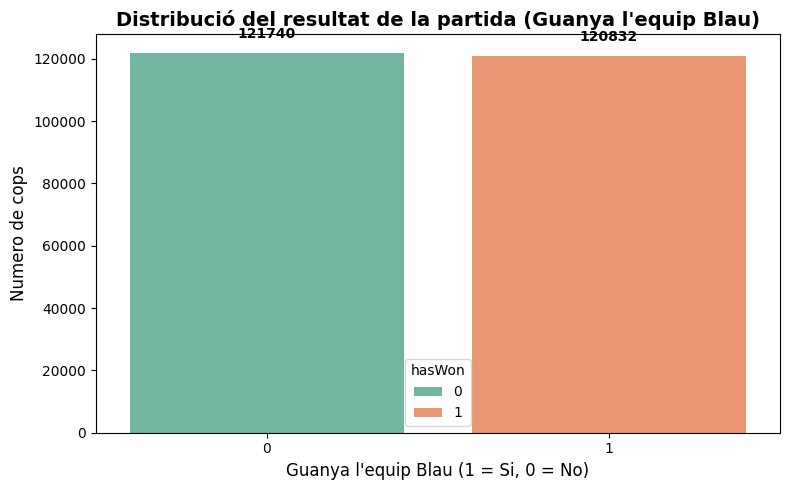

In [7]:
# Distribució de la variable objectiu
print(df["hasWon"].value_counts())
print("\nPercentatge de la distribució:")
print(df["hasWon"].value_counts(normalize=True) * 100)

# Visualització de la distribució
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="hasWon", hue="hasWon",  palette="Set2")
plt.title("Distribució del resultat de la partida (Guanya l'equip Blau)", fontsize=14, fontweight="bold")
plt.xlabel("Guanya l'equip Blau (1 = Si, 0 = No)", fontsize=12)
plt.ylabel("Numero de cops", fontsize=12)
for i, v in enumerate(df["hasWon"].value_counts()):
    plt.text(i, v + 5000, str(v), ha="center", fontweight='bold')
plt.tight_layout()
plt.show()

- **Partides Perdudes (hasWon=0)**: 121,740 (50.19%)
- **Partides Guanyades (hasWon=1)**: 120,832 (49.81%)
- **Diferència**: Quasi perfectament equilibrat (0.38% de diferència)

Amb aquests resultats, podem determinar el següent:

1. **Dataset equilibrat**:
   - No hi ha biaix cap a una classe (no hi ha més victòries que derrotes)
   - Percentatges 50-50 són ideals per entrenar classificadors
   - No necessitarem técniques de balanceig (SMOTE, class weights, etc.)

2. **Implicacions per al Model**:
   - **Baseline accuracy**: 50% (predicció aleatòria donarà 50% d'exactitud)
   - **Target per millorar**: El nostre model hauria d'assolir un número superior a aquest 50%.
   - **No hi ha overfitting**: Dataset equilibrat

### 4.4 Correlació entre variables i la variable objectiu
Analitzem la correlació entre les variables numèriques i la variable objectiu per tal de determinar quines dades són les que ens ajudaran a predir quin equip guanyarà.

,hasWon
hasWon,1.000000
goldDiff,0.607487
champLevelDiff,0.580956
expDiff,0.575538
destroyedBotInnerTurret,0.227670
kills,0.219807
destroyedBotNexusTurret,0.204864
destroyedBotOuterTurret,0.197713
isFirstTower,0.196205
killedFireDrake,0.181943


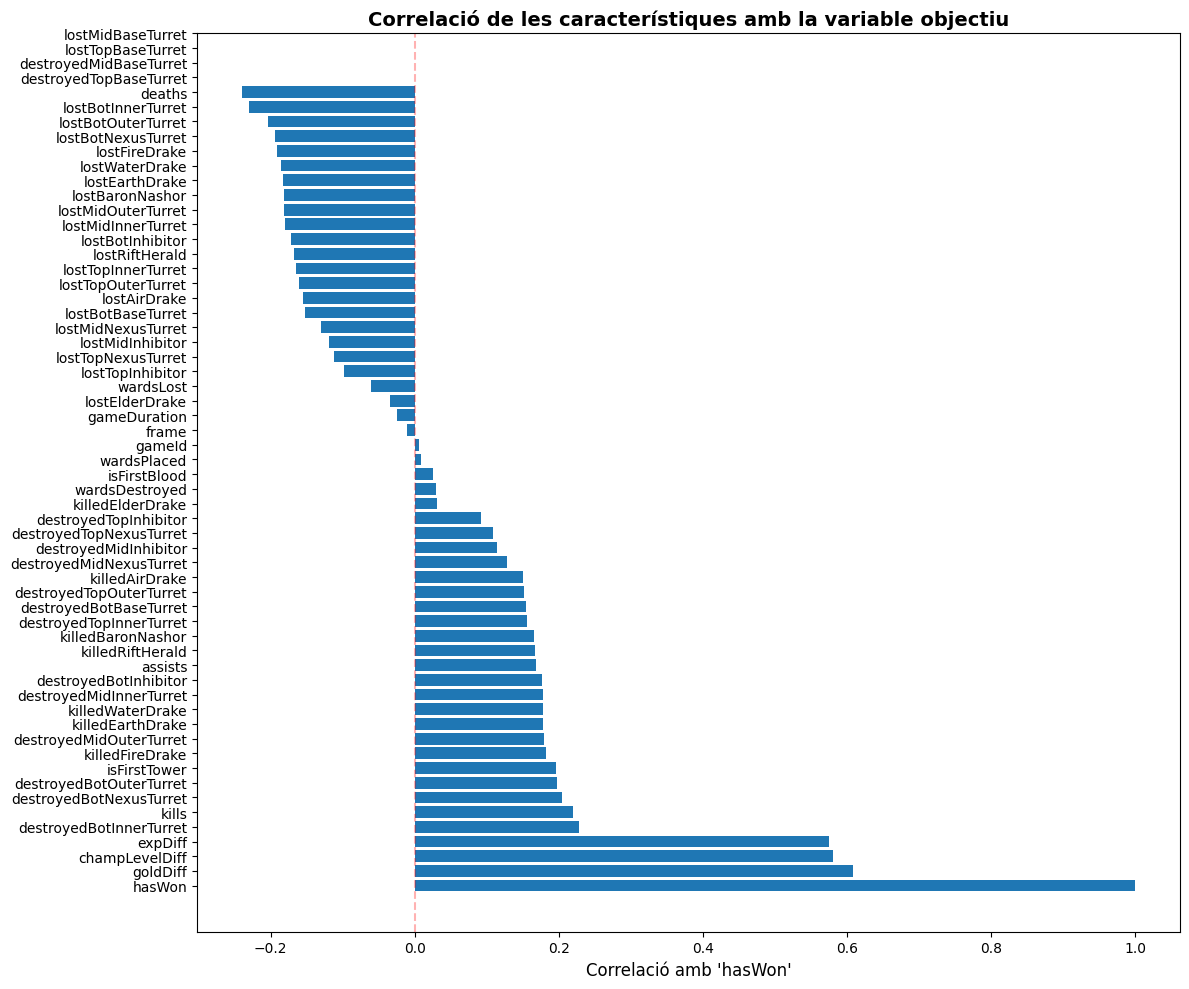

In [8]:
# Correlació de variables amb la variable objectiu
correlation_with_target = df.corr()["hasWon"].sort_values(ascending=False)

html = f"""
<div style="max-height:300px; overflow-y:auto; overflow-x:auto; 
            border:1px solid #ccc; padding:6px;">
    {correlation_with_target.to_frame().to_html()}
</div>
"""

display(HTML(html))


# Visualization of correlation with target
plt.figure(figsize=(12, 10))
plt.barh(range(len(correlation_with_target)), correlation_with_target.values)
plt.yticks(range(len(correlation_with_target)), correlation_with_target.index)
plt.xlabel("Correlació amb 'hasWon'", fontsize=12)
plt.title("Correlació de les característiques amb la variable objectiu", fontsize=14, fontweight="bold")
plt.axvline(x=0, color="r", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Podem veure que hi han atributs obviament correlats amb la nostra variable objectiu, però volem veure quins són els atributs que tenen una correlació més directe amb el que volem predir. Anem a veure quins són aquests atributs:

In [9]:
correlation_threshold = 0.19 # Ajustat per incloure més atributs, no només el parell dels més forts
useful = {
    col: correlation_with_target[col]
    for col in correlation_with_target.index
    if abs(float(correlation_with_target[col])) > correlation_threshold
}


# Ordenem per força de correlació
sorted_useful = sorted(useful.items(), key=lambda x: abs(x[1]), reverse=True)

print("Total of useful attributes:", len(sorted_useful)-1)
print("Useful attributes (sorted):")
for col, corr in sorted_useful:
    if col != "hasWon":
     print(f"{col:30s}  corr = {corr:.4f} \n")


Total of useful attributes: 13
Useful attributes (sorted):
goldDiff                        corr = 0.6075 

champLevelDiff                  corr = 0.5810 

expDiff                         corr = 0.5755 

deaths                          corr = -0.2403 

lostBotInnerTurret              corr = -0.2299 

destroyedBotInnerTurret         corr = 0.2277 

kills                           corr = 0.2198 

destroyedBotNexusTurret         corr = 0.2049 

lostBotOuterTurret              corr = -0.2034 

destroyedBotOuterTurret         corr = 0.1977 

isFirstTower                    corr = 0.1962 

lostBotNexusTurret              corr = -0.1945 

lostFireDrake                   corr = -0.1914 



**Predictors més importants:**
1. **goldDiff**: La diferència d'or és el millor predictor de victòria.
   - Equips guanyadors dominen econòmicament els equips perdedors.

2. **champLevelDiff**: La diferència d'experiència
   - Si vas per sobre en experiència, vas per sobre també en nivell, és la conseqüència de 'expDiff'.
   
3. **expDiff**: La diferència d'experiència és quasi tan important com l'or.
   - Indica control general del joc i kills/farm.
   
4. **destroyedBotInnerTurret, destroyedBotNexusTurret, destroyedBotOuterTurret**: Destruir les estructures de la linia inferior són les que més afecten al resultat:
   
5. **kills**: Més kills = més probabilitat de guanyar

**Correlacions negatives importants:**
- **deaths**: Més morts = menys probabilitat de guanyar.
- **lostBotInnerTurret, lostBotOuterTurret, destroyedBotNexusTurret, destroyedBotOuterTurret**: Que et destrueixin les estructures de la linia inferior, afecta més que perdre les de les altres línies.
- **lostFireDrake**: Els dracs de foc és l'objectiu que afecta més al resultat de la partida, augmentant les probabilitats de perdre.

Per tant, les estructures de la linia inferior, kills/deaths i la diferencia d'estadistiques entre equips són les característiques que més s'han de tenir en compte a l'hora de fer el nostre model. L'unica estadistica a recalcar dels monstres com a objectiu, és el drac de foc. Per tant, analitzarem més detalladament aquestes característiques a continuació.

### 4.5 Anàlisi per trams temporals (frames)
Analitzem com els predictors més importants canvien al llarg del joc, per fer això analitzem les estadístiques en els diferents 'frames'. 

Partides uniques totals: {24912}
Registres totals (frames): {242572}
Mitjana de frames per partida: 9.74

Estadístiques de durada de la partida (milisegons):


,gameDuration
count,2.425720e+05
mean,1.785494e+06
std,3.761901e+05
min,5.490000e+05
25%,1.532000e+06
50%,1.774000e+06
75%,2.025000e+06
max,3.428000e+06


Distribució de frames:


,count
frame,
10,24912
12,24842
14,24716
16,24502
18,23430
20,22632
22,20951
24,18818
26,16086


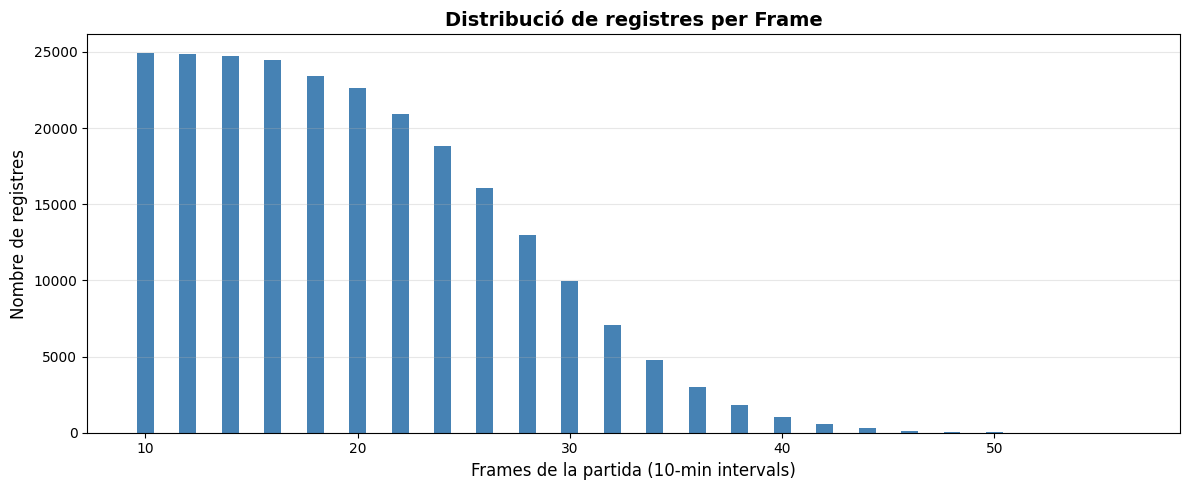

In [10]:
# Anàlisis de la distribució temporal
print("Partides uniques totals:", {df['gameId'].nunique()})
print("Registres totals (frames):", {len(df)})
print(f"Mitjana de frames per partida: {len(df) / df['gameId'].nunique():.2f}")

def show_scrollable(obj, max_height=300):
    """Mostra Series o DataFrames dins d'un div scrollable."""
    # Converteix a DataFrame per garantir format taula
    if isinstance(obj, pd.Series):
        obj = obj.to_frame()

    html = f"""
    <div style="max-height:{max_height}px; overflow-y:auto; overflow-x:auto;
                border:1px solid #ccc; padding:6px;">
        {obj.to_html()}
    </div>
    """
    display(HTML(html))


print("\nEstadístiques de durada de la partida (milisegons):")
show_scrollable(df['gameDuration'].describe())

print("Distribució de frames:")
show_scrollable(df['frame'].value_counts().sort_index())

# Visualització de frames
plt.figure(figsize=(12, 5))
frame_counts = df['frame'].value_counts().sort_index()
plt.bar(frame_counts.index, frame_counts.values, color='steelblue')
plt.xlabel("Frames de la partida (10-min intervals)", fontsize=12)
plt.ylabel("Nombre de registres", fontsize=12)
plt.title("Distribució de registres per Frame", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Estructura del dataset:**
- **24,912 partides úniques** amb una mitjana de 9.74 registres per partida
- **Frames temporals**: Des del frame 10 (minut 10) fins al frame 56 (minut 56)
- **Dropout natural**: Només 1,013 partides arriben al frame 40, la resta es decideixen abans
  
**Implicacions:**
1. **Duració mitjana**: aproximadament 30 minuts per partida (1,785,494 ms ~= 29.7min)
2. **Distribució de frames**: La majoria de partides acaben entre frame 20-26 (minuts 20-26)
3. **Decisivitat**: La meitat de partides estan decidides al frame 22 (minut 22)

Podem determinar que els frames inicials (10-14) són importants per establir dominància i garàntir la victoria. I tampoc és comú acabar abans d'aquest temps. Tenint en compte aquesta distribució, anem a veure com les estadístiques evolucionen durant el transcurs d'una partida.

### 4.6 Evolució de les estadístiques de joc per frame

Mitjana de les estadístiques per frame i status guanyador:


frame,hasWon,goldDiff,expDiff,champLevelDiff,kills,deaths
10,0,-1153.235109,-923.141195,-0.211574,4.922493,6.711226
10,1,1215.184066,859.972247,0.196156,6.781243,4.841614
12,0,-1722.137384,-1374.511948,-0.285330,6.573026,9.034994
12,1,1816.679363,1288.133632,0.267296,9.100744,6.487797
14,0,-2392.247742,-1868.422016,-0.351818,8.301684,11.501749
14,1,2518.439920,1733.852394,0.331332,11.609980,8.217867
16,0,-3069.257609,-2468.302814,-0.432012,10.025515,14.028222
16,1,3219.743767,2310.111102,0.409453,14.158532,9.922277
18,0,-3469.556060,-2842.446938,-0.462116,11.928308,16.524882
18,1,3602.460230,2616.652914,0.432463,16.653084,11.847724


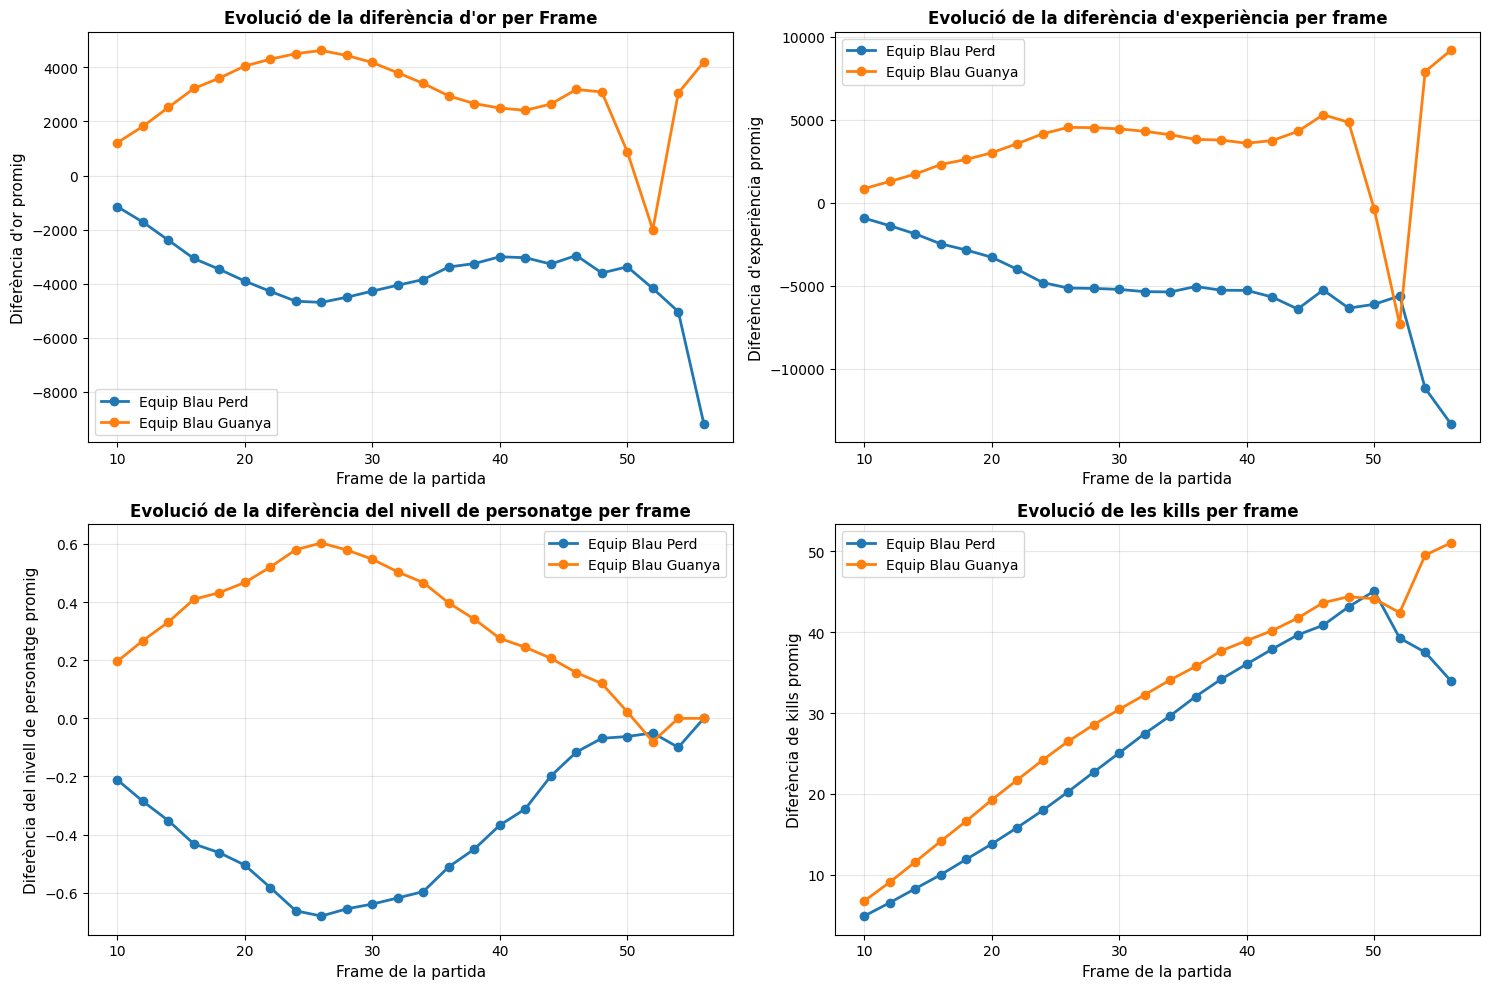

In [11]:
# Anàlisis de l'evolució per frame de les estadístiques clau per les partides guanyades vs perdudes
# Agrupar per frame i calcular la mitjana per a les partides guanyades i perdudes
frame_stats = df.groupby(['frame', 'hasWon']).agg({
    'goldDiff': 'mean',
    'expDiff': 'mean',
    'champLevelDiff': 'mean',
    'kills': 'mean',
    'deaths': 'mean'
}).reset_index()

print("Mitjana de les estadístiques per frame i status guanyador:")

def show_scrollable(obj, max_height=300):
    """Mostra Series o DataFrames dins d'un div scrollable."""
    if isinstance(obj, pd.Series):
        obj = obj.to_frame()
    html = f"""
    <div style="max-height:{max_height}px; overflow-y:auto; overflow-x:auto;
                border:1px solid #ccc; padding:6px;">
        {obj.to_html(index=False)}
    </div>
    """
    display(HTML(html))

show_scrollable(frame_stats.head(20))


# Visualització de l'evolució per frames
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Diferencia d'evolució de l'or
ax = axes[0, 0]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Equip Blau Guanya' if won_status == 1 else 'Equip Blau Perd'
    ax.plot(data['frame'], data['goldDiff'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Frame de la partida', fontsize=11)
ax.set_ylabel("Diferència d'or promig", fontsize=11)
ax.set_title("Evolució de la diferència d'or per Frame", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Diferencia d'evolució de l'experiència
ax = axes[0, 1]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Equip Blau Guanya' if won_status == 1 else 'Equip Blau Perd'
    ax.plot(data['frame'], data['expDiff'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Frame de la partida', fontsize=11)
ax.set_ylabel("Diferència d'experiència promig", fontsize=11)
ax.set_title("Evolució de la diferència d'experiència per frame", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Diferencia d'evolució del nivell de personatge
ax = axes[1, 0]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Equip Blau Guanya' if won_status == 1 else 'Equip Blau Perd'
    ax.plot(data['frame'], data['champLevelDiff'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Frame de la partida', fontsize=11)
ax.set_ylabel("Diferència del nivell de personatge promig", fontsize=11)
ax.set_title("Evolució de la diferència del nivell de personatge per frame", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Evolució de les kills
ax = axes[1, 1]
for won_status in [0, 1]:
    data = frame_stats[frame_stats['hasWon'] == won_status]
    label = 'Equip Blau Guanya' if won_status == 1 else 'Equip Blau Perd'
    ax.plot(data['frame'], data['kills'], marker='o', label=label, linewidth=2)
ax.set_xlabel('Frame de la partida', fontsize=11)
ax.set_ylabel('Diferència de kills promig', fontsize=11)
ax.set_title('Evolució de les kills per frame', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Fase inicial (Frame 10-14):**
- Diferència d'or inicial: ±1,200-2,400 entre equips.
- Diferència de kills: Els guanyadors ja porten 6-8 kills, perdedors 4-5.
- Els equips que dominen early game mantenen l'avantatge quasi tota la partida.

**Fase mitja (Frame 16-26):**
- **Màxim de diferència d'or**: aproximadament 4,500 d'or al frame 26.
- **Diferència de kills**: Els guanyadors acumulen 26+ kills, perdedors 20+.

**Fase final (Frame 28+):**
- Les diferències comencen a estabilitzar-se.
- El finals està decidit per una bona jugada (una bona batalla es definitiva)
- Com hi ha un màxim de nivell per personatge (nivell 18 per a tothom), aquesta estadística aconsegueix equilibrar-se-

### 4.7 Anàlisi d'objectius épics (Dracs, Baron Nashor, Rift Herald)
Analitzem la importància de la captura dels monstres épics en la victòria.

Average objective metrics by win status:


,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald
hasWon,,,,,,,,,,,,,,
0,0.2035,0.2086,0.2246,0.2111,0.0031,0.4074,0.4109,0.3963,0.4164,0.0085,0.0771,0.2329,0.4533,0.7334
1,0.3890,0.3926,0.3799,0.3968,0.0080,0.2089,0.2162,0.2334,0.2225,0.0029,0.2060,0.0831,0.6762,0.5005


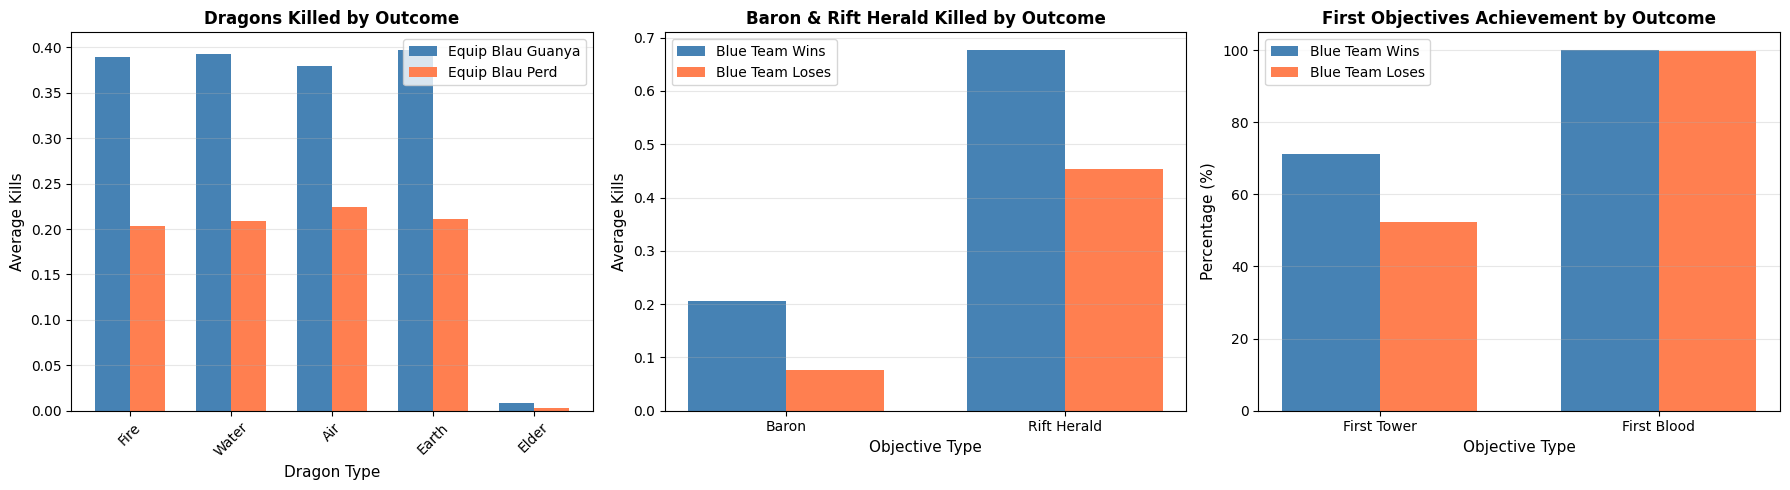

In [12]:
# Dracs aconseguits i perduts
dragons_data = df.groupby('hasWon').agg({
    'killedFireDrake': 'mean',
    'killedWaterDrake': 'mean',
    'killedAirDrake': 'mean',
    'killedEarthDrake': 'mean',
    'killedElderDrake': 'mean',
    'lostFireDrake': 'mean',
    'lostWaterDrake': 'mean',
    'lostAirDrake': 'mean',
    'lostEarthDrake': 'mean',
    'lostElderDrake': 'mean',
    'killedBaronNashor': 'mean',
    'lostBaronNashor': 'mean',
    'killedRiftHerald': 'mean',
    'lostRiftHerald': 'mean',
}).round(4)

print("Average objective metrics by win status:")

html = f"""
<div style="max-height:300px; overflow-y:auto; overflow-x:auto;
            border:1px solid #ccc; padding:6px;">
    {dragons_data.to_html()}
</div>
"""

display(HTML(html))

# Visualització dels objectius
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dracs
ax = axes[0]
dragon_types = ['Fire', 'Water', 'Air', 'Earth', 'Elder']
wins = [df[df['hasWon']==1]['killedFireDrake'].mean(),
        df[df['hasWon']==1]['killedWaterDrake'].mean(),
        df[df['hasWon']==1]['killedAirDrake'].mean(),
        df[df['hasWon']==1]['killedEarthDrake'].mean(),
        df[df['hasWon']==1]['killedElderDrake'].mean()]
losses = [df[df['hasWon']==0]['killedFireDrake'].mean(),
          df[df['hasWon']==0]['killedWaterDrake'].mean(),
          df[df['hasWon']==0]['killedAirDrake'].mean(),
          df[df['hasWon']==0]['killedEarthDrake'].mean(),
          df[df['hasWon']==0]['killedElderDrake'].mean()]

x = np.arange(len(dragon_types))
width = 0.35
ax.bar(x - width/2, wins, width, label='Equip Blau Guanya', color='steelblue')
ax.bar(x + width/2, losses, width, label='Equip Blau Perd', color='coral')
ax.set_xlabel('Dragon Type', fontsize=11)
ax.set_ylabel('Average Kills', fontsize=11)
ax.set_title('Dragons Killed by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(dragon_types, rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Baron and Rift Herald
ax = axes[1]
objectives = ['Baron', 'Rift Herald']
wins_obj = [df[df['hasWon']==1]['killedBaronNashor'].mean(),
            df[df['hasWon']==1]['killedRiftHerald'].mean()]
losses_obj = [df[df['hasWon']==0]['killedBaronNashor'].mean(),
              df[df['hasWon']==0]['killedRiftHerald'].mean()]

x = np.arange(len(objectives))
ax.bar(x - width/2, wins_obj, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses_obj, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Objective Type', fontsize=11)
ax.set_ylabel('Average Kills', fontsize=11)
ax.set_title('Baron & Rift Herald Killed by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(objectives)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Primers objectius
ax = axes[2]
first_objs = ['First Tower', 'First Blood']
wins_first = [df[df['hasWon']==1]['isFirstTower'].mean() * 100,
              df[df['hasWon']==1]['isFirstBlood'].mean() * 100]
losses_first = [df[df['hasWon']==0]['isFirstTower'].mean() * 100,
                df[df['hasWon']==0]['isFirstBlood'].mean() * 100]

x = np.arange(len(first_objs))
ax.bar(x - width/2, wins_first, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses_first, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Objective Type', fontsize=11)
ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('First Objectives Achievement by Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(first_objs)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Dracs:**
- **Guanyadors vs Perdedors:**
  - Fire Drake: 0.39 kills vs 0.20 (95% més per guanyadors).
  - Water Drake: 0.39 vs 0.21 (86% més).
  - Air Drake: 0.38 vs 0.22 (73% més).
  - Earth Drake: 0.40 vs 0.21 (90% més).
  
Cada drac capturat augmenta significativament les probabilitats de guanyar. Els equips predestinats a guanyar són els que tenen un major control sobre els dracs.

**Baron Nashor:**
- **Guanyadors**: promig de 0.21 kills.
- **Perdedors**: promig de 0.08 kills.
- 260% més per guanyadors - Aquest és l'objectiu més decisiu. El problema és que la partida es sol decidir abans de la seva aparició. Els equips que fan Baron rarament perden la partida després

**Rift Herald:**
- **Guanyadors**: 0.68 kills (67.6% de les partides)
- **Perdedors**: 0.45 kills (45.3% de les partides)
És més accessible que el Baron, però afecta menys al resultat de la partida.

**Primers objectius:**
- **First Tower**: Guanyadors 72%, Perdedors 28%. Per tant fer-se la primera Torreta té un efecte sobre la partida.
- **First Blood**: Guanyadors 50%, Perdedors 50%. No té sentit fer cas, tenim un 50% de possibilitats d'encertar el resultat amb aquesta característica, no té efecte real sobre la partida.

Podem concluir que el control d'objectius (monstres) és millor predictor de victòria que les estadístiques de combat, però només si s'arriba al moment de disputar aquests objectius.

### 4.8 Análisi de destrucció d'estructures
Analitzem la relació entre la destrucció d'estructures defensives i la victòria.

Average tower/inhibitor destruction metrics by win status:


,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret
hasWon,,,,,,,,,,,,,,,
0,0.0079,0.0096,0.0328,0.0131,0.0143,0.0400,0.0,0.0,0.0083,0.0701,0.0602,0.1035,0.3063,0.2949,0.2749
1,0.0361,0.0507,0.1430,0.0514,0.0634,0.1638,0.0,0.0,0.0961,0.1715,0.1748,0.2832,0.4533,0.4695,0.4658


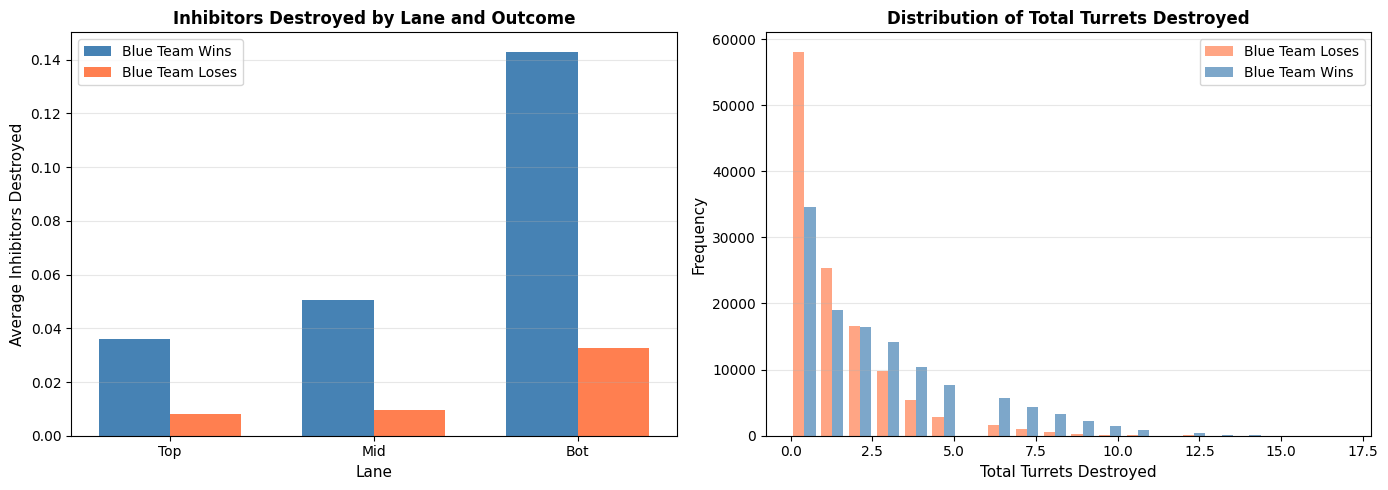

In [13]:
tower_inhibitor_stats = df.groupby('hasWon').agg({
    'destroyedTopInhibitor': 'mean',
    'destroyedMidInhibitor': 'mean',
    'destroyedBotInhibitor': 'mean',
    'destroyedTopNexusTurret': 'mean',
    'destroyedMidNexusTurret': 'mean',
    'destroyedBotNexusTurret': 'mean',
    'destroyedTopBaseTurret': 'mean',
    'destroyedMidBaseTurret': 'mean',
    'destroyedBotBaseTurret': 'mean',
    'destroyedTopInnerTurret': 'mean',
    'destroyedMidInnerTurret': 'mean',
    'destroyedBotInnerTurret': 'mean',
    'destroyedTopOuterTurret': 'mean',
    'destroyedMidOuterTurret': 'mean',
    'destroyedBotOuterTurret': 'mean',
}).round(4)

print("Average tower/inhibitor destruction metrics by win status:")

html = f"""
<div style="max-height:300px; overflow-y:auto; overflow-x:auto;
            border:1px solid #ccc; padding:6px;">
    {tower_inhibitor_stats.to_html()}
</div>
"""

display(HTML(html))

# Nombre total de torres i inhibidors destruits
df['totalTurretsDestroyed'] = (df['destroyedTopInhibitor'] + df['destroyedMidInhibitor'] + 
                               df['destroyedBotInhibitor'] + df['destroyedTopNexusTurret'] + 
                               df['destroyedMidNexusTurret'] + df['destroyedBotNexusTurret'] +
                               df['destroyedTopBaseTurret'] + df['destroyedMidBaseTurret'] + 
                               df['destroyedBotBaseTurret'] + df['destroyedTopInnerTurret'] + 
                               df['destroyedMidInnerTurret'] + df['destroyedBotInnerTurret'] +
                               df['destroyedTopOuterTurret'] + df['destroyedMidOuterTurret'] + 
                               df['destroyedBotOuterTurret'])

df['totalInhibitorsDestroyed'] = (df['destroyedTopInhibitor'] + df['destroyedMidInhibitor'] + 
                                   df['destroyedBotInhibitor'])

# Visualització
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inhibidors per linia
ax = axes[0]
lanes = ['Top', 'Mid', 'Bot']
wins_inh = [df[df['hasWon']==1]['destroyedTopInhibitor'].mean(),
            df[df['hasWon']==1]['destroyedMidInhibitor'].mean(),
            df[df['hasWon']==1]['destroyedBotInhibitor'].mean()]
losses_inh = [df[df['hasWon']==0]['destroyedTopInhibitor'].mean(),
              df[df['hasWon']==0]['destroyedMidInhibitor'].mean(),
              df[df['hasWon']==0]['destroyedBotInhibitor'].mean()]

x = np.arange(len(lanes))
width = 0.35
ax.bar(x - width/2, wins_inh, width, label='Blue Team Wins', color='steelblue')
ax.bar(x + width/2, losses_inh, width, label='Blue Team Loses', color='coral')
ax.set_xlabel('Lane', fontsize=11)
ax.set_ylabel('Average Inhibitors Destroyed', fontsize=11)
ax.set_title('Inhibitors Destroyed by Lane and Outcome', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(lanes)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Distribució del total d'estructures destruides
ax = axes[1]
wins_data = df[df['hasWon']==1]['totalTurretsDestroyed']
losses_data = df[df['hasWon']==0]['totalTurretsDestroyed']

ax.hist([losses_data, wins_data], bins=20, label=['Blue Team Loses', 'Blue Team Wins'], 
        color=['coral', 'steelblue'], alpha=0.7)
ax.set_xlabel('Total Turrets Destroyed', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Total Turrets Destroyed', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Quan mirem quins equips aconsegueixen trencar inhibidors, veiem que és un dels senyals més clars de qui acabarà guanyant la partida.

* Top: els equips guanyadors trenquen l’inhibidor unes 4 vegades més sovint que els perdedors.

* Mid: la diferència encara és més marcada: els guanyadors el destrueixen 5 cops més sovint.

* Bot: la diferència també és enorme: els guanyadors el trenquen quatre vegades més que els equips que perden.

Per tant, si un equip aconsegueix un inhibidor, és molt probable que acabi guanyant la partida.
I de tots, els de la línia inferior destaca com el més decisiu: controlar aquesta línia sol marcar el resultat de la partida.


Per altra banda, els equips que guanyen destrueixen aproximadament 2,5 vegades més torres que els perdedors.


### 4.9 Anàlisi de Visió (Wards)
Analitzem la importància del control de visió en la partida.

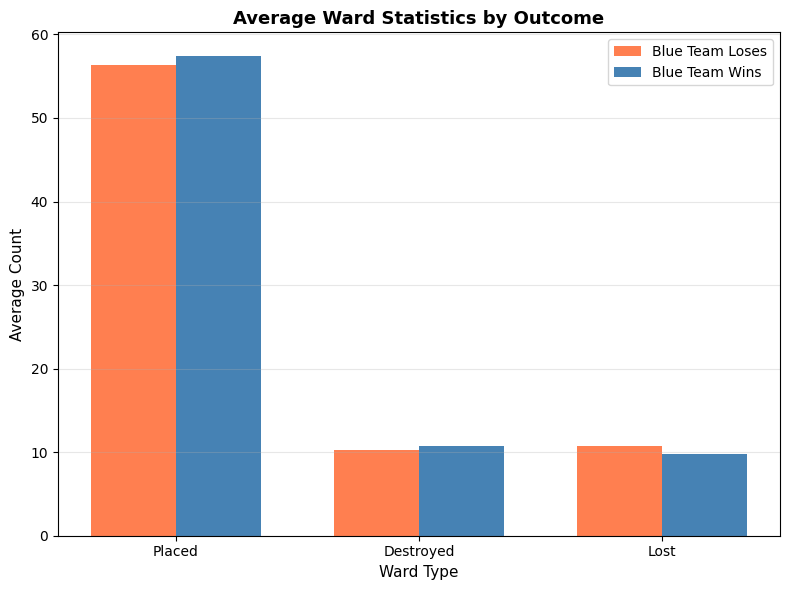

In [14]:
# Calcul de mitjanes
wins_mean = [
    df[df['hasWon']==1]['wardsPlaced'].mean(),
    df[df['hasWon']==1]['wardsDestroyed'].mean(),
    df[df['hasWon']==1]['wardsLost'].mean()
]

losses_mean = [
    df[df['hasWon']==0]['wardsPlaced'].mean(),
    df[df['hasWon']==0]['wardsDestroyed'].mean(),
    df[df['hasWon']==0]['wardsLost'].mean()
]

# Visualització
plt.figure(figsize=(8, 6))

x = np.arange(3)
width = 0.35

plt.bar(x - width/2, losses_mean, width, label='Blue Team Loses', color='coral')
plt.bar(x + width/2, wins_mean,   width, label='Blue Team Wins',  color='steelblue')

plt.xlabel('Ward Type', fontsize=11)
plt.ylabel('Average Count', fontsize=11)
plt.title('Average Ward Statistics by Outcome', fontsize=13, fontweight='bold')
plt.xticks(x, ['Placed', 'Destroyed', 'Lost'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Quan comparem les estadístiques de wards entre equips que guanyen i equips que perden, observem que les diferències són molt petites. Tant els guanyadors com els perdedors col·loquen, destrueixen i perden pràcticament el mateix nombre de wards. Els guanyadors posen només una mica més de wards que els perdedors (una diferència irrellevant del 2%) i també destrueixen lleugerament més wards enemics (només un 5% més) i perden una mica menys de wards (un 10% menys).

Aquesta informació ens indica que la quantitat de wards no és un bon indicador de victòria ja que els dos equips tenen comportaments molt similars en termes de visió.

Com a resultat, té sentit eliminar o reduir la importància d’aquestes variables per evitar soroll i millorar el rendiment del model.